In [1]:
from scipy.io import mmread
from scipy.sparse import csr_matrix
import anndata as ad
import os, sys, time
import mira
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.INFO)


In [3]:
os.chdir("../../")

In [4]:
os.getcwd()

'/home/CMML_mini2_final'

In [5]:
arguments = ["run/vertical/MIRA_run.py", "data/GSE156478/Control", "run_res/vertical/GSE156478_Ctrl/"]

if not os.path.exists(arguments[1]):
    print("Input 10xMultiome Data does not exist.")

# argument 1 is the path to the input file family, no / end
# argument 2 save path of the results, end will automatically add MIRA.csv, no /end
# example (in project root):
# python run/vertical/MIRA_run.py data/brain_SNARE  run_res/vertical/brain_SNARE/

print("Input file: "+ arguments[1] + " \n")
print("Data Name: "+ arguments[2] + " \n")

# 10x multiome
path = arguments[1]
# gene expression
cell_names = pd.read_csv(path+'/RNA/barcodes.tsv', sep = '\t', header=None, index_col=None)
cell_names.columns =  ['cell_ids'] 
X = csr_matrix(mmread(path+'/RNA/matrix.mtx').T)
gene_names = pd.read_csv(path+'/RNA/features.tsv', sep = '\t',  header=None, index_col=None) 
gene_names.columns =  ['gene_ids'] 
adata_RNA = ad.AnnData(X, obs=pd.DataFrame(index=cell_names.cell_ids), var=pd.DataFrame(index = gene_names.gene_ids))
adata_RNA.var_names_make_unique()

# peak information
cell_names = pd.read_csv(path+'/ATAC/barcodes.tsv', sep = '\t', header=None, index_col=None)
cell_names.columns =  ['cell_ids'] 
X = csr_matrix(mmread(path+'/ATAC/matrix.mtx').T)
peak_name = pd.read_csv(path+'/ATAC/features.tsv',header=None,index_col=None)
peak_name.columns = ['peak_ids']
adata_ATAC  = ad.AnnData(X, obs=pd.DataFrame(index=cell_names.cell_ids), var=pd.DataFrame(index = peak_name.peak_ids))


start_time = time.time() #From now on time
adata_RNA.var.index = adata_RNA.var.index.str.upper()
adata_RNA.var_names_make_unique()

rawdata = adata_RNA.X.copy()
sc.pp.highly_variable_genes(
    adata_RNA,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=False
)

sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)
adata_RNA.layers['counts'] = rawdata
del rawdata

Input file: data/GSE156478/Control 

Data Name: run_res/vertical/GSE156478_Ctrl/ 



In [6]:
model_rna = mira.topics.make_model(
    adata_RNA.n_obs, adata_RNA.n_vars, # helps MIRA choose reasonable values for some hyperparameters which are not tuned.
    feature_type = 'expression',
    highly_variable_key='highly_variable',
    counts_layer='counts',
)

In [7]:
learn_rate = model_rna.get_learning_rate_bounds(adata_RNA)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.0009066484626424173, 0.48935619397222907)


<Axes: xlabel='Learning Rate', ylabel='Loss'>

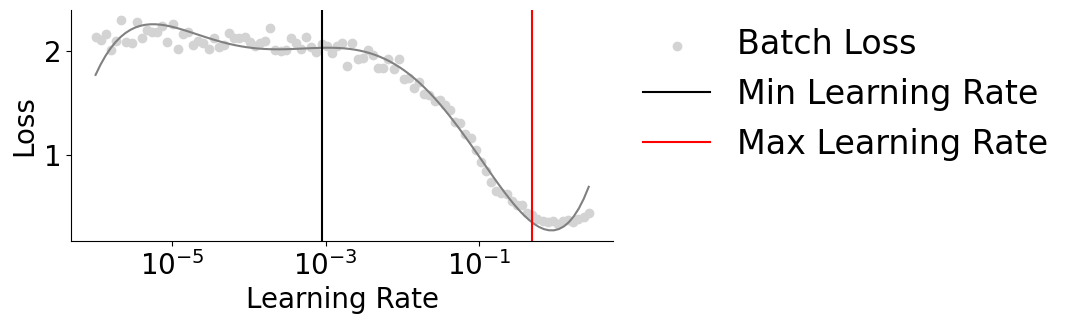

In [9]:
model_rna.set_learning_rates(learn_rate[0], learn_rate[1]) # for larger datasets, the default of 1e-3, 0.1 usually works well.
# model_rna.plot_learning_rate_bounds(figsize=(7,3))
topic_contributions = mira.topics.gradient_tune(model_rna, adata_RNA)
NUM_TOPICS = int(sum(np.array(topic_contributions)>0.07))
# mira.pl.plot_topic_contributions(topic_contributions, NUM_TOPICS)
model_rna = model_rna.set_params(num_topics = NUM_TOPICS).fit(adata_RNA)
model_rna.predict(adata_RNA)

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Predicting latent vars:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Predicting latent vars:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [10]:
sc.pp.filter_cells(adata_ATAC, min_genes=10)
sc.pp.filter_genes(adata_ATAC, min_cells=1)
sc.pp.highly_variable_genes(
    adata_ATAC,
    flavor="seurat_v3",
    n_top_genes=30000,
    subset=False
)

model_atac = mira.topics.make_model(
    *adata_ATAC.shape,
    feature_type = 'accessibility',
    endogenous_key='highly_variable', # which peaks are used by the encoder network
)

learn_rate = model_atac.get_learning_rate_bounds(adata_ATAC)

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: Fu

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (7.598460377690624e-06, 0.25838184961070676)


In [11]:
model_atac.set_learning_rates(learn_rate[0], learn_rate[1]) # for larger datasets, the default of 1e-3, 0.1 usually works well.
# model.plot_learning_rate_bounds(figsize=(7,3))
topic_contributions = mira.topics.gradient_tune(model_atac, adata_ATAC)

NUM_TOPICS = int(sum(np.array(topic_contributions)>0.05))
# mira.pl.plot_topic_contributions(topic_contributions, NUM_TOPICS)
model_atac = model_atac.set_params(num_topics = NUM_TOPICS).fit(adata_ATAC)

model_atac.predict(adata_ATAC)
# adata_ATAC.obsm['X_umap_features'].shape

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Predicting latent vars:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Predicting latent vars:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [12]:
adata_RNA, adata_ATAC = mira.utils.make_joint_representation(adata_RNA, adata_ATAC)
latent = adata_ATAC.obsm['X_joint_umap_features']

# sc.pp.neighbors(adata_ATAC, use_rep = 'X_joint_umap_features', metric = 'manhattan',
#                n_neighbors = 20)
np.savetxt(arguments[2]+"MIRA.csv",latent, delimiter=',')
end_time = time.time()

execution_time = end_time - start_time
print(f"running time:{execution_time} s")

INFO:mira.adata_interface.utils:7468 out of 7468 cells shared between datasets (100%).
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/mira-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


running time:1908.0267107486725 s
